In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Introduction
2. Load and check data
* 2.1 load data
* 2.2 Outlier detection
* 2.3 joining train and test set
* 2.4 check for null and missing values
3. Feature analysis
* 3.1 Numerical values
* 3.2 Categorical values
4. Filling missing values
* 4.1 Age
5. Feature Engineering
* 5.1 Name/Title
* 5.2 Family Size
* 5.3 Cabin
* 5.4 Ticket
6. Modeling
* 6.1 Simple modeling
  * 6.1.1 Cross validate models
  * 6.1.2 Hyperparameter tunning for best models
  * 6.1.3 Plots learning curves
  * 6.1.4 Feature importances of the tree based classifiers
* 6.2 Ensemble models
   * 6.2.1 Combining models
* 6.3 Prediction
  * 6.3.1 Predict and Submit results

## 1. Introduction
첫 번째로 피처 분석을 하며 엔지니어링에 집중하겠습니다. 마지막 파트는 voting 을 통해 타이타닉의 모델링과 생존을 예측에 관한 것을 고려합니다.  
  
이 스크립트는 크게 세 부분으로 나뉩니다:  
* Feature analysis  
* Feature engineering
* Modeling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check data
### 2.1 Load data

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle study/Titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle study/Titanic/test.csv')
IDtest = test["PassengerId"]

### 2.2 Outlier detection

In [4]:
def detect_outliers(df, n, features):
  # IQR(Inter Quantile Range) 방식으로 아웃라이어 처리하기

  outlier_indices = []

  for col in features:
    # 1st quantile(25%)
    Q1 = np.percentile(df[col], 25)
    # 3rd quantile(75%)
    Q3 = np.percentile(df[col], 75)
    # Interquantile rane(IQR)
    IQR = Q3 - Q1

    outlier_step = 1.5 * IQR

    # 인덱스의 리스트 정의 피처 컬럼의 아웃라이어에 대한
    outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

    # 정의한 컬럼들의 아웃라이어 인덱스를 추가하기
    outlier_indices.extend(outlier_list_col)

    # 3개 이상의 아웃라이어를 포함하는 관측치들을 선택하기
  outlier_indices = Counter(outlier_indices)
  multiple_outliers = list( k for k, v in outlier_indices.items() if v > n) 

  return multiple_outliers

Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"]) # 왜 3개 이상의 중복 결측치를 제거하는지

## Fare를 제외한 피처들은 아웃라이어가 있는지 의문. 아웃라이어가 있다고 하더라도 크지 않은  수준일텐데 왜 제거하는지?

In [5]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 아웃라이어를 관측했습니다. 28, 89, 342 승객은 높은 티켓 비용을 냈습니다. 나머지 7명은 매우 높은 SibSp 값을 가졌습니다.

### 2.3 joining train and test set

In [6]:
train_len = len(train)
dataset = pd.concat(objs = [train, test], axis=0).reset_index(drop=True)

train과 test 데이터셋을 합쳤습니다. 따라서 같은 피처의 수를 얻을 수 있습니다. 범주형 변환을 할 때

### check for null and missing values

In [7]:
dataset = dataset.fillna(np.nan)

dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Age와 Cabin features는 결측치에 있어 중요한 파트입니다.  
Susvived 결측치는 test 데이터셋에 해당합니다. (Survived 컬럼은 테스트셋에 없으며 train, test 셋을 합칠 때 NaN값으로 대체했습니다.)

In [8]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
#summarize data and get statistics

train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Feature analysis

### 3.1 Numerical values

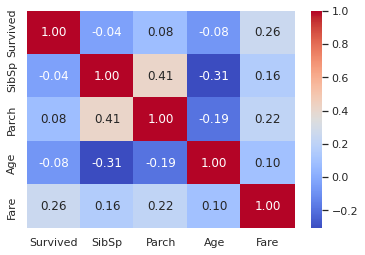

In [12]:
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt = ".2f", cmap="coolwarm")

Fare feature만이 생존 확률과 의미 있는 상관관계를 가지고 있는듯 합니다.  
  
이는 다른 피처들이 쓸모 없다는 의미는 아닙니다. 이러한 피처들의 부분은 생존과 관계가 있을 수 있습니다. 이를 결정 짓기 위해 이러한 피처들의 세부사항들을 탐색해야 합니다.

**SIbSp**

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


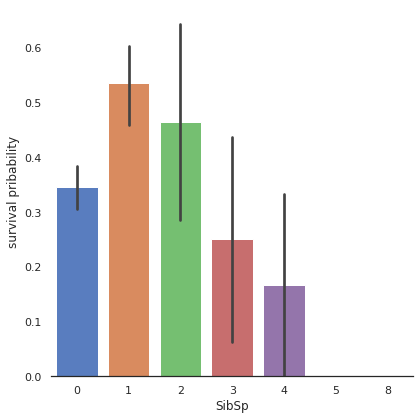

In [13]:
g = sns.factorplot(x = "SibSp", y = "Survived", data=train, kind="bar", size = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival pribability")

많은 형제와 배우자를 둔 승객들은 생존률이 낮은듯 보입니다.  
  
혼자, 혹은 두 명이 서로 함께 있는 (SibSp 1or 2) 승객들은 생존률이 높은 것 같습니다.  
  
이러한 관찰은 꽤 흥미로운데, 우리는 새로운 피처로 고려할 수 있습니다. 이러한 범주를 설명하는

**Parch** 

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


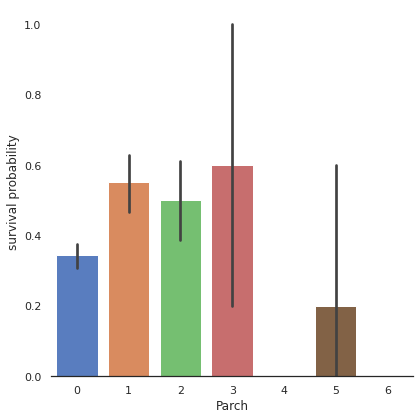

In [14]:
g = sns.factorplot(x = "Parch", y = "Survived", data = train, kind = "bar", size = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

작은 가족들은 생존 확률이 더 높습니다. 싱글(Pacrh 0), 중간(Parch 3,4) 그리고 대가족(Parch 5,6)보다.  
  
부모/아이가 3명인 승객들의 생존에 있어 중요한 표준편차가 있다는 것에 유의하세요.

**Age**

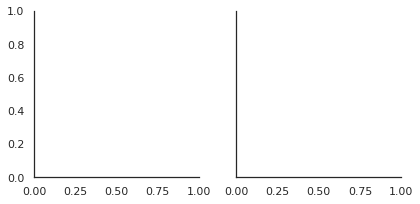

In [17]:
g = sns.FacetGrid(train, col='Survived')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


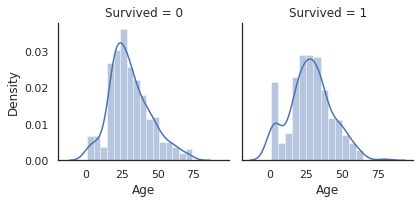

In [16]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

Age 분포는 꼬리를 갖는듯 합니다. 아마 가우시안 분포일 것입니다.  
  
나이 분포들이 생존, 그리고 생존하지 못한 하위 집단에 따라서 같지 않다는 것을 알았습니다. 젊은 승객에 해당하는 봉우리가 있는데, 그들은 살아남았습니다. 또한 60-80 나이의 승객들은 거의 생존하지 못했음을 알 수 있습니다.  
  
따라서, "Age"가 "Survived"와 상관관계를 가지지 않더라도 승객들의 나이 범주에 따라서 더 많거나 적은 생존률이 있다는 것을 확인할 수 있습니다.  
  
매우 젊은 승객들은 더 많은 생존 기회를 얻은듯 합니다.

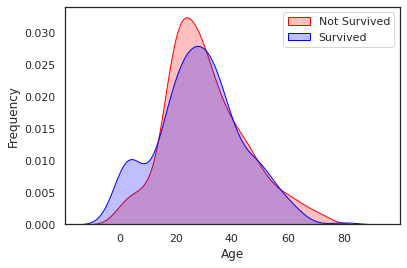

In [20]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax = g, color = "Blue", shade = True)

g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

두 분포를 겹쳐 놓았을 때, 명확하게 볼 수 있습니다. 아기들과 매우 어린 아이들에 관한 봉우리를(0에서 5살 사이)

**Fare**

In [21]:
dataset["Fare"].isnull().sum()

1

In [22]:
# 중앙 값으로 결측치를 채워줍니다.
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

하나의 결측치를 가지고 있기 때문에 중앙 값을 사용해 채우기로 결정했습니다. 이는 예측에 있어 중대한 결과를 가져오지 않을 것입니다.

In [28]:
dataset["Fare"].skew()

4.3695095504693855

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


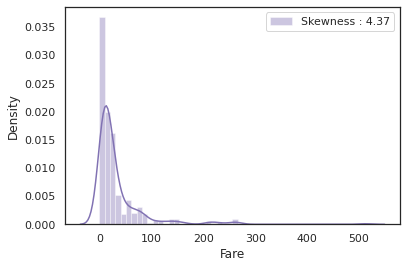

In [26]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best") # best 입력시 자동으로 최적화된 위치에 배치

요금 분포는 매우 편향됐습니다. 이는 모델을 매우 높은 값으로 이끌 수 있습니다. scalsed 된다고 하더라도.  
  
이런 경우, log 함수로 변환해 왜곡을 줄여 주는 것이 좋습니다.

In [29]:
dataset["Fare"] = dataset["Fare"].map(lambda i : np.log(i) if i > 0 else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


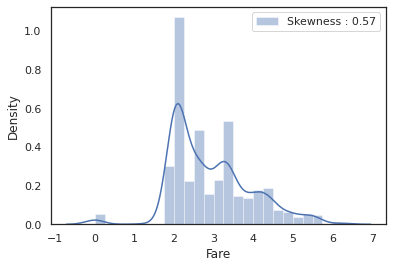

In [30]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

로그 변환 이후 확실히 왜곡 정도가 줄었습니다.

### 3.2 Categorical values

**Sex**

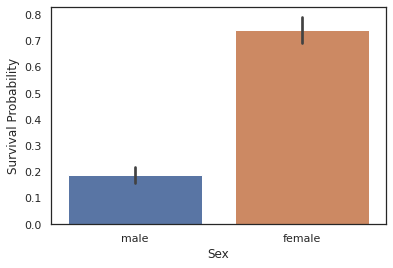

In [31]:
g = sns.barplot(x = "Sex", y = "Survived", data=train)
g = g.set_ylabel("Survival Probability")

In [32]:
train[["Sex", "Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


남자는 생존률에 있어 여성보다 낮은 기회를 가졌다는 것이 매우 확실합니다.  
  
따라서 성별은 아마 생존을 예측하는데 있어 중요한 역할을 할 것입니다.  


**Pclass**

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


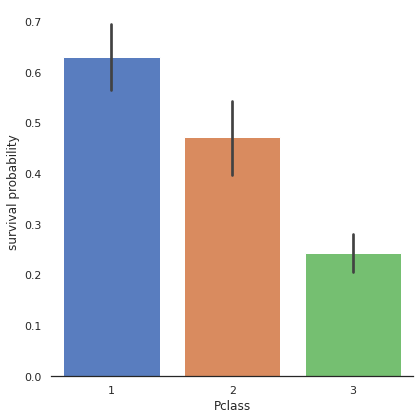

In [33]:
g = sns.factorplot(x = "Pclass", y = "Survived", data=train, kind = "bar", size = 6, palette = "muted")
g.despine(left = True)
g = g.set_ylabels("survival probability")

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


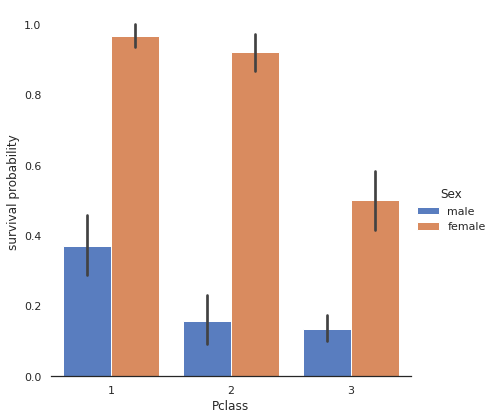

In [35]:
g = sns.factorplot(x = "Pclass", y = "Survived", hue = "Sex", data = train,
                   size = 6, kind = "bar", palette = "muted")
g.despine(left = True)
g = g.set_ylabels("survival probability")

승객 생존률은 3 클래스가 돌링하지 않습니다. 일등석 승객들은 더욱 높은 생존 기회를 얻었습니다. 2, 3등석 승객에 비해  
  
이러한 추세는 남성과 여성 승객들 모두를 볼 때 유효합니다.

**Embarked**

In [36]:
dataset["Embarked"].isnull().sum()

2

In [37]:
# Embarked의 nan 값을 가장 흔한 값인 "S"로 채웁니다.
dataset["Embarked"] = dataset["Embarked"].fillna("S")

두 개의 결측치가 있기 때문에 이를 가장 흔한 값인 Embarked "S"로 채우기로 했습니다.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


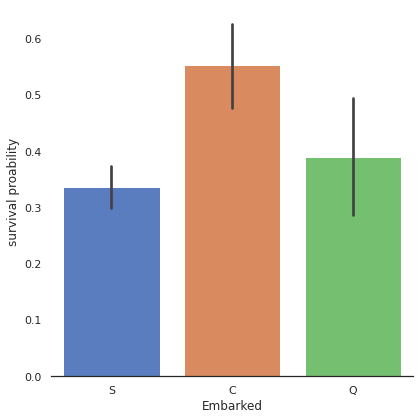

In [39]:
g = sns.factorplot(x = "Embarked", y = "Survived", data = train,
                  size = 6, kind = "bar", palette = "muted")
g.despine(left = True)
g = g.set_ylabels("survival proability")

Cherbourg(C)에서 온 승객들이 더욱 많은 생존 기회를 얻은 듯 합니다.  
  
Queenstown(Q)과 Southampton(S) 보다 Cherbourg(C)의 1등석 승객 비율이 높아서인 것이 가설입니다.  
  
Embarked와 Pclass의 분포를 비교해 봅시다.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


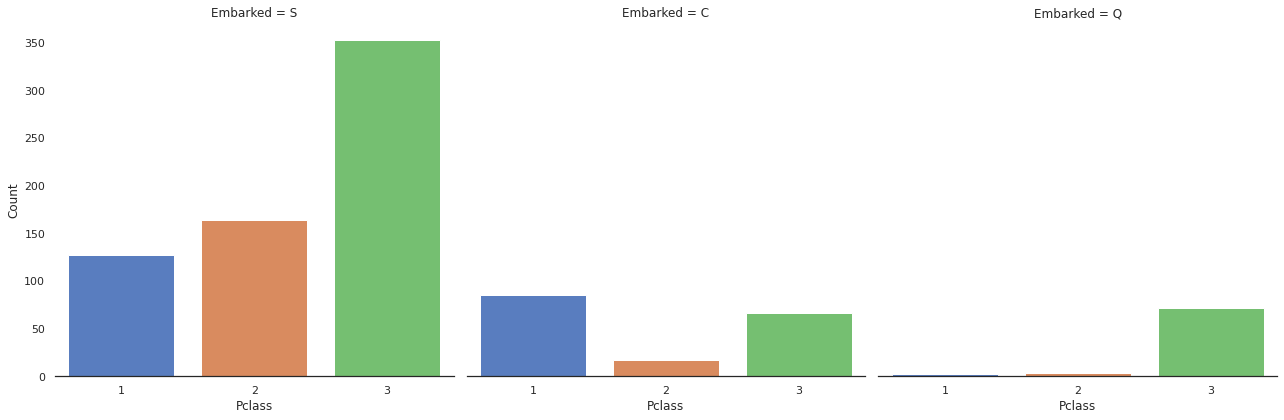

In [42]:
g = sns.factorplot("Pclass", col = "Embarked", data = train,
                   size = 6, kind = "count", palette = "muted")
g.despine(left = True)
g = g.set_ylabels("Count")

역시 세 번째 class는 Southampton(S)와 Quenstown(Q)에서 온 승객들이 가장 흔했습니다. 반면 Cherbourg 승객들은 거의 1등석 이었으며 이 좌석은 가장 높은 생존률을 가졌습니다.  
  
왜 일등석 승객들의 생촌률이 높은지는 설명할 수 없습니다. 가설은 일등석 승객들이 탈출하는데 우선순위를 가졌다는 것입니다. 그들의 영향력을 이용해서

## 4. Filling missing Values

### 4.1 Age

확인했듯 Age 컬럼은 전체 데이터셋에 걸쳐 256개의 결측치를 가지고 있습니다.  
  
더 많은 생존 기회를 갖은 하위 집단이 있기 때문에(예를 들어 아이들), 연령의 측성을 유지해서 결측치를 씌우는 것이 바람직합니다.  
  
이러한 문제를 해결하기 위해 나이와 가장 높은 상관관계를 가지는 피처를 살펴보겠습니다. (Sex, Parch, Pclass, and SibSp).

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr

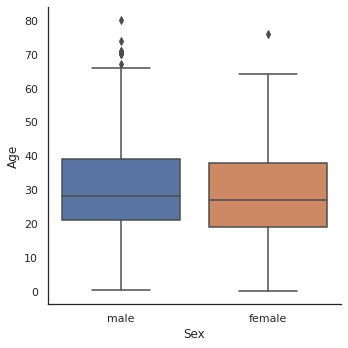

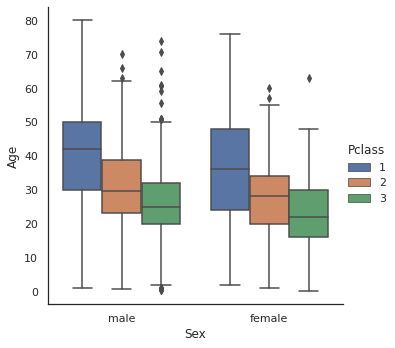

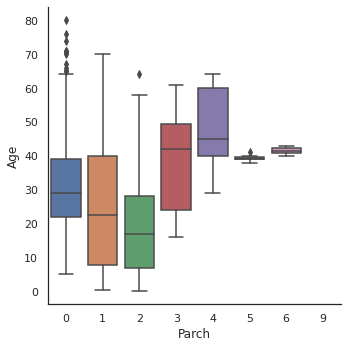

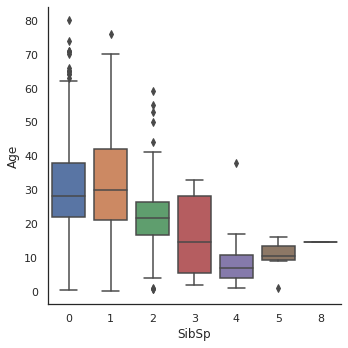

In [44]:
g = sns.factorplot(y = "Age", x = "Sex", data=dataset, kind="box")
g = sns.factorplot(y = "Age", x = "Sex", hue = "Pclass", data = dataset, kind = "box")
g = sns.factorplot(y = "Age", x = "Parch", data = dataset, kind = "box")
g = sns.factorplot(y = "Age", x = "SibSp", data = dataset, kind = "box")

Age 분포는 남성, 여성의 하위 집단이 똑같은 것 같습니다 .따라서 나이를 예측하는데 성별은 정보가 되지 않습니다.  
  
반면 1등성 승객은 2등석 승객등보다 나이가 많으며 또한 2등석 승객은 3등석 승객보다 그렇습니다.  
  
나아가서 승객이 부모나 아이를 많이 가질수록 더 나이가 많으며 형제자매/배우자를 많이 가질수록 어립니다.

In [46]:
# 성별 범주값 전환: 남자=0, 여자=1
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female": 1})

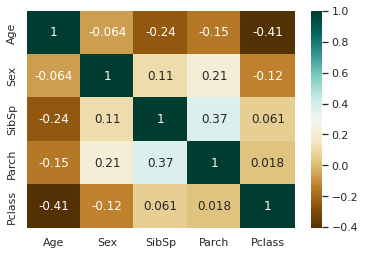

In [47]:
g = sns.heatmap(dataset[["Age", "Sex", "SibSp", "Parch", "Pclass"]].corr(), cmap = "BrBG", annot=True)

상관관계 맵은 확인합니다. Parch를 제외한 factorplot 관측치를. 나이는 성별과 상관관계를 가지고 있지 않지만 Pclass, Parch, SibSp는 음의 상관관계를 가지고 있습니다.  
  
Parch의 함수의 Age 플롯은 Age는 커집니다. 부모/아이의 수가 증가하며. 하지만 전체적인 상관관계는 negative입니다.  
  
따라서 SibSp, Parch, Pclass를 사용하기로 결정했습니다. 나이의 결측치를 채우는데 있어서.  
  
이 전략은 Age를 채우는 것입니다. 비슷한 행의 중간 나이로 Pclass나 Parch, 그리고 SibSp에 따라서

In [50]:
dataset["SibSp"] == dataset.iloc[11]["SibSp"]

0       False
1       False
2        True
3       False
4        True
        ...  
1304     True
1305     True
1306     True
1307     True
1308    False
Name: SibSp, Length: 1309, dtype: bool

In [52]:
# 결측치가 있는 사람과 똑같은 SibSp, Parch, Pclass인 사람의 중위 나이대를 가져옴

index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age:
  age_med = dataset["Age"].median()
  age_pred = dataset["Age"][((dataset["SibSp"] == dataset.iloc[i]["SibSp"])&
                                            (dataset["Parch"] == dataset.iloc[i]["Parch"])&
                                            (dataset["Pclass"] == dataset.iloc[i]["Pclass"]))].median()
  if not np.isnan(age_pred):
    dataset['Age'].iloc[i] = age_pred # 안비었으면 age_pred
  else:
    dataset['Age'].iloc[i] = age_med # 비었으면 age_med

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


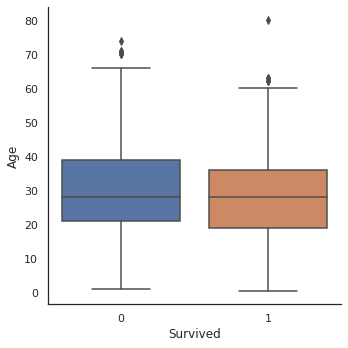

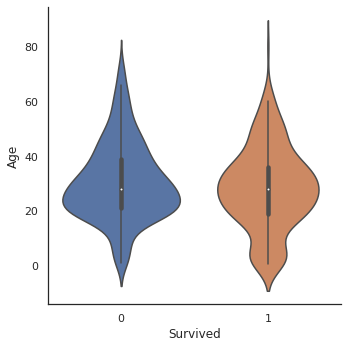

In [53]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

나이의 중위값 간에는 차이가 없습니다. 생존, 그리고 생존하지 못한 하위 집단에서.  
  
하지만 생존한 승객들의 바이올린 플롯에서 매우 젊은 승객들이 높은 생존률을 거진다는 것을 알 수 있습니다.

## 5. Feature engineering

**5.1 Name/Title**

In [54]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Name 피처는 승객의 직함에 대한 정보가 포함돼 있습니다.  
  
어떤 승객들의 구별되는 직함이 탈출에 있어서 선호됐을 수 있습니다. 따라서 모델에 이들을 추가하는 것은 흥미로울 것입니다.

In [56]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [57]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

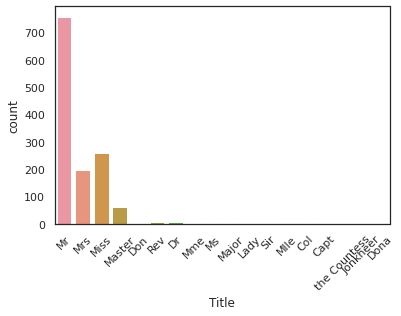

In [60]:
g = sns.countplot(x = "Title", data=dataset)
g = plt.setp(g.get_xticklabels(), rotation = 45)

데이터셋에는 17개의 타이틀이 있으며 그 중 대부분은 매우 희귀합니다. 따라서 4개의 카테고리로 그룹화 하겠습니다.

In [62]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


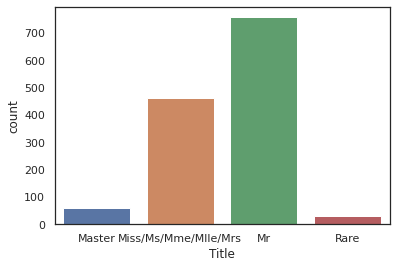

In [63]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


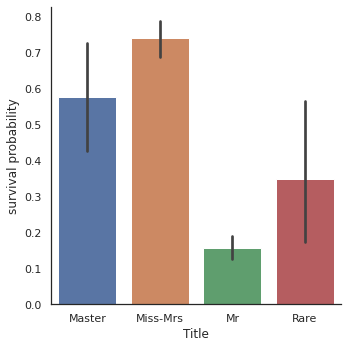

In [64]:
g = sns.factorplot(x = "Title", y = "Survived", data = dataset, kind = "bar")
g = g.set_xticklabels(["Master", "Miss-Mrs", "Mr", "Rare"])
g = g.set_ylabels("survival probability")

"여성과 아이 먼저"  
희귀한 직함을 가진 승객들이 더 많은 생존 기회가 있었다는 점이 흥미롭습니다.